In [1]:
import IGIMF
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.integrate as integr

In [2]:
mass_metals: float = 1e7 # [Msun]
mass_gas: float = 1e9 # [Msun]
M_pgal: float = 1e10 # [Msun]
downsizing_time: float = 10 # [yr] 
t: float = 1 # [Gyr]

In [4]:
igimf = IGIMF.IGIMF(mass_metals, mass_gas, M_pgal)#, downsizing_time, t)

In [5]:
resolution = 50
M_ecl_v = np.logspace(np.log10(igimf.M_ecl_min), np.log10(igimf.M_ecl_max), num=resolution)
m_v = np.logspace(np.log10(igimf.m_star_min), np.log10(igimf.m_star_max), num=resolution)

In [6]:
k_ecl, M_max = igimf.normalization(igimf.embedded_cluster_mass_function, igimf.SFR * igimf.delta_t, igimf.M_ecl_min, igimf.M_ecl_max)

In [8]:
#[igimf.embedded_cluster_mass_function(M) for M in M_ecl_v]
k_ecl, M_max, ECMF_func, ECM_weighted_func = igimf.ECMF()
ECMF_v = [M * ECMF_func(M) for M in M_ecl_v]
ECMF_integral = integr.simpson(ECMF_v, x=M_ecl_v) 
np.log10(np.abs(ECMF_integral- igimf.SFR * igimf.delta_t))


6.004948677064697

In [9]:
ECMF_integral

104211218.87334211

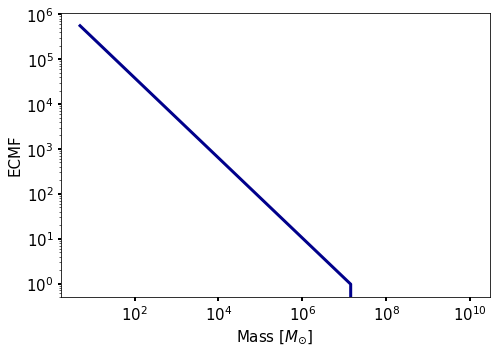

In [10]:
def IMF_plot(m_v, IMF_v, k, m_max, name : str, num_colors=1):
    from matplotlib import pyplot as plt
    import matplotlib.ticker as ticker
    cm = plt.cm.get_cmap(name='plasma')
    currentColors = [cm(1.*i/num_colors) for i in range(num_colors)]
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    ax.loglog(m_v,IMF_v, linewidth=3, color='darkblue')
    ax.set_ylabel(name, fontsize=15)
    ax.set_xlabel(r'Mass $[M_{\odot}]$', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.tick_params(width=2)
    fig.tight_layout()
    plt.savefig(f'IMF_plot_{name}.pdf', bbox_inches='tight')
    #plt.show(block=False)
    return None
IMF_plot(M_ecl_v, ECMF_v, k_ecl, M_max, 'ECMF')

In [14]:
k_ecl, M_max, ECMF_func, ECMF_weighted_func = igimf.ECMF()
sIMF = pd.DataFrame([igimf.stellar_IMF(M, ECMF_weight=ECMF_func(M))  for M in M_ecl_v], columns=['kstar', 'm_max', 'func', 'func_weighted', 'alpha_3'])
#sIMF = pd.DataFrame([igimf.stellar_IMF(M)  for M in M_ecl_v], columns=['kstar', 'm_max', 'func', 'func_weighted', 'alpha_3'])
sIMF_func = sIMF['func'].values 

In [15]:
def IMF_3D_plot(m_v, M_ecl_v, sIMF_func):
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt
    
    def z_func(m,M):
        return np.reshape([[sIMF_func[i](m_j) for m_j in m] for i,val in enumerate(M)], (len(m), len(M)))
    
    def resh(x):
        return np.reshape(list(x) * len(x), (len(x),len(x)))
    
    fig = plt.figure(figsize=(10,8))
    # syntax for 3-D projection
    ax = plt.axes(projection ='3d')
    m = resh(m_v)
    M = resh(M_ecl_v).T
    xi = z_func(m_v, M_ecl_v)
    
    # plotting
    #ax.plot3D(x, y, z, 'green')
    ax.plot_surface(np.log10(m), np.log10(M), np.ma.log10(xi), cmap ='plasma', linewidth=0.25)
    ax.set_xlabel(r'stellar mass $m_{\star}$ [$\log_{10}(M_{\odot})$]', fontsize=15)
    ax.set_ylabel(r'E. cluster mass $M_{\rm ecl}$ [$\log_{10}(M_{\odot})$]', fontsize=15)
    ax.set_zlabel(r'$\xi_{\star}={\rm d}N_{\star}/ {\rm d} m$', fontsize=15)
    ax.set_title(r'stellar IMF $\xi_{\star}(m_{\star},M_{\rm ecl},Z)$', fontsize=17)
    fig.tight_layout()
    plt.show(block=False)
    plt.savefig(f'IMF_plot_3D.pdf', bbox_inches='tight')
    
    print(f'\nFor every cluster mass, integrate the stellar IMF over the stellar mass range:\n')
    print([integr.simpson(xi[i],x=m_v) for i,_ in enumerate(M_ecl_v)])
    print(f'\nFor every cluster mass, the mass of the cluster will be:\n')
    print([integr.simpson([xi[i]* m for m in m_v],x=m_v) for i,_ in enumerate(M_ecl_v)])

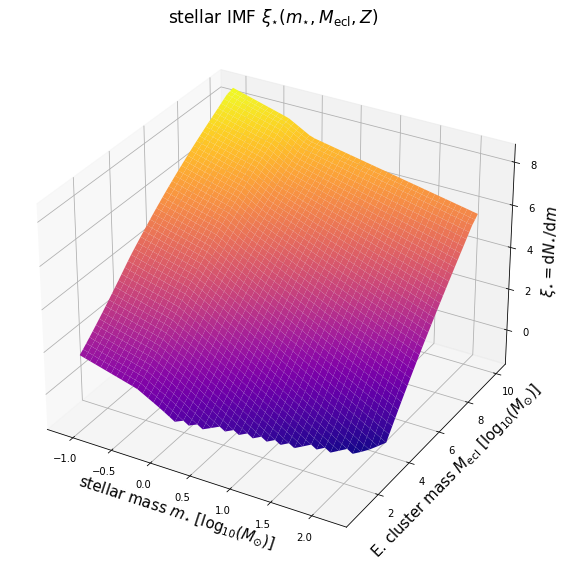


For every cluster mass, integrate the stellar IMF over the stellar mass range:

[12.53608715656387, 18.026966361363574, 26.01921486162625, 37.55358624869496, 54.8824352997281, 80.61561806183205, 119.0166955235748, 176.5713761802184, 263.1745059324499, 393.9660222175521, 591.9587053059352, 893.3529528521823, 1353.1292486792026, 2056.4262617170357, 3136.232492468235, 4797.4033766850835, 7239.805792142537, 10549.383264837665, 15328.95043725137, 22199.44271805706, 32026.35468578815, 46002.876494428914, 65765.15996847996, 93543.36396215911, 132360.37143595555, 186293.20136872184, 260817.3240849791, 363261.61959808547, 503411.62938854424, 694308.873622145, 953338.5008975682, 1303667.8681288506, 1776265.9644676785, 2412422.3923441973, 3267572.0533619034, 4416331.905181706, 5958527.363954764, 8034235.631378865, 10834905.978305586, 14578165.91434063, 19693646.723755892, 26600521.07957165, 35943458.213157676, 49034082.83640302, 66191839.633446805, 92454403.44601333, 127595250.96540205, 17799798

<Figure size 432x288 with 0 Axes>

In [16]:
IMF_3D_plot(m_v, M_ecl_v, sIMF_func)